In [1]:
import numpy as np
import dynamiqs as dq

|██████████| 100.0% ◆ elapsed 1.29s ◆ remaining 0.00ms     
100%|██████████| 50/50 [00:04<00:00, 10.94it/s]


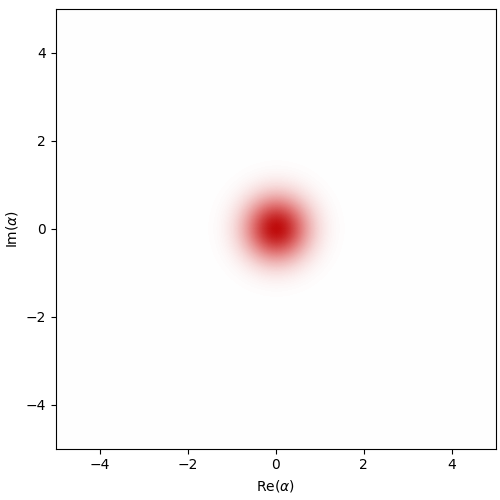

In [2]:
# Parameters
na = 20 # Hilbert space dimension
nb = 5
g2 = 1
epsilon_d = -4
kappa_b = 10

adag = dq.create(na)
a = dq.destroy(na)
a_id, id = dq.destroy(na, nb)
bdag = dq.create(nb)
b = dq.destroy(nb)
id, id_bdag = dq.create(na, nb)
H_2ph = g2 * dq.tensor(adag @ adag, b) + dq.dag(g2 * dq.tensor(adag @ adag, b))
H_d = epsilon_d * id_bdag + dq.dag(epsilon_d * id_bdag)

psi0 = dq.fock((na, nb), (0, 0)) # initial state
H = H_2ph + H_d
# H = dq.zero(na)
kappa_2 = 1 # two-photon loss rate
alpha = 2.0 # cat size
tsave = np.linspace(0, 4, 100)
loss_op = dq.asqarray(np.sqrt(kappa_b)*dq.dag(id_bdag), dims=(20,5)) # loss operator
res = dq.mesolve(H, [loss_op], psi0, tsave)
states = dq.ptrace(res.states, 0, (na,nb))
dq.plot.wigner_gif(states)


# Gradient Descent Optimization of Time-Dependent Drive

This code performs gradient descent optimization to find the optimal drive amplitude ε_d(t) that creates a target quantum state. The drive is represented as a piecewise constant function, discretized into 100 time steps over a duration of 3.0 time units.

1. **Time Discretization**:
   - Total time T = 3.0
   - Number of time steps = 100
   - Each element in ε_d represents the drive amplitude for one time step

2. **Loss Function**:
   - Evolves the quantum state using the master equation
   - Calculates fidelity with target Fock state |n=4⟩
   - Returns 1 - fidelity (to minimize)

4. **Optimization**:
   - Initial guess: ε_d(t) = -4.0 for all t
   - Learning rate = 1.0

The gradient descent optimizes over the entire vector of drive amplitudes simultaneously, finding the time-dependent control that best creates our target state.

In [ ]:
import jax
import jax.numpy as jnp

T = 3.0
nit = 20  # Number of time steps
tsave = jnp.linspace(0, T, nit)
id, id_bdag = dq.create(na, nb)

def loss_function(eps_d):
    """Calculate loss for given piecewise constant control"""
    # Two-photon exchange Hamiltonian (time-independent)
    H_2ph = g2 * dq.tensor(adag @ adag, b) + dq.dag(g2 * dq.tensor(adag @ adag, b))
    
    def H_d_t(t):
        # Use jnp.asarray to handle both QArray and float inputs
        t_val = jnp.asarray(t, dtype=float)
        # Convert time to index
        idx = jnp.clip(jnp.floor(t_val/T * (nit-1)), 0, nit-1).astype(jnp.int32)
        return eps_d[idx] * id_bdag + jnp.conj(eps_d[idx]) * id_bdag
    
    H_d = dq.timecallable(lambda t: H_d_t(t))  # Ensure dimensions match
    H = H_2ph + H_d
    
    # Evolve system
    result = dq.mesolve(H, [loss_op], psi0, tsave)
    
    # Calculate expectation value of number operator
    n_final = dq.ptrace(result.states, 0, (na,nb))[-1]
    print(n_final, dq.fock(na, 4))
    
    # Loss is difference from target alpha squared
    val = 1 - dq.fidelity(n_final, dq.fock(na, 4))
    return val

# Initial guess for epsilon_d
eps_d_list = np.array([-3.0 for _ in range(nit)])

# Gradient descent parameters
learning_rate = 1
num_iterations = 25

# Compile gradient function
grad_fn = jax.jit(jax.grad(loss_function))

# Store loss history
loss_history = []

# Gradient descent loop
for i in range(num_iterations):
    # Calculate gradient
    grad = grad_fn(eps_d_list)
    # Update parameters
    eps_d_list = eps_d_list - learning_rate * grad
    
    # Calculate and store loss
    loss = loss_function(eps_d_list)
    print(grad)
    print(loss)

QArray: shape=(20, 20), dims=(20,), dtype=complex64, layout=dense
Traced<ShapedArray(complex64[20,20])>with<JVPTrace> with
  primal = Traced<ShapedArray(complex64[20,20])>with<DynamicJaxprTrace>
  tangent = Traced<ShapedArray(complex64[20,20])>with<JaxprTrace> with
    pval = (ShapedArray(complex64[20,20]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7c44a44cdb20>, in_tracers=(Traced<ShapedArray(complex64[1,20,20]):JaxprTrace>,), out_tracer_refs=[<weakref at 0x7c44a440c0e0; to 'JaxprTracer' at 0x7c44a440d8f0>], out_avals=[ShapedArray(complex64[20,20])], primitive=squeeze, params={'dimensions': (0,)}, effects=frozenset(), source_info=<jax._src.source_info_util.SourceInfo object at 0x7c44d817edd0>, ctx=JaxprEqnContext(compute_type=None, threefry_partitionable=True, cur_abstract_mesh=None, xla_metadata={})) QArray: shape=(20, 1), dims=(20,), dtype=complex64, layout=dense
Traced<ShapedArray(complex64[20,1])>with<DynamicJaxprTrace>


|██████████| 100.0% ◆ elapsed 939.23ms ◆ remaining 0.00ms  
|          |   0.0% ◆ elapsed 02m14s ◆ remaining 0.00ms  

In [ ]:
eps_d_list

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tsave, eps_d_list)
plt.xlabel('Time')
plt.ylabel(r'$\epsilon_d$')
plt.show()